현재영역 접기 <br>
Ctrl + Shift + [  : Windows and Linux <br>
⌥ + ⌘ + [  : Mac <br>
현재영역 펼치기 <br>
Ctrl + Shift + ]  : Windows and Linux <br>
⌥ + ⌘ + ]  : Mac <br>
전체 접기 <br>
Ctrl + K + 0(숫자)  : Windows and Linux <br>
⌘ + K + 0 (숫자) : Mac <br>
전체 펼치기 <br>
Ctrl + K + J : Windows and Linux <br>
⌘ + K + J : Mac <br>

A : 현재 셀에서 위쪽에 새로운 셀을 추가한다.
B : 현재 셀에서 아래쪽에 새로운 셀을 추가한다.
DD : 현재 셀을 삭제한다.
M : 현재 셀을 코드에서 마크다운으로 변경한다.
Y : 현재 셀을 마크다운에서 코드로 변경한다.
※ 어째선지 바로 가기 키에서는 C가 코드로 변경하는 단축키라고 한다. 무시하자.
C, V, X : 각각 복사, 붙여넣기, 잘라내기이다.

#### Import libraries

In [291]:
import argparse
import datetime
import random
import time
from pathlib import Path
from PIL import Image
import os

import numpy as np
import torch
from torch.utils.data import DataLoader, DistributedSampler
from PIL import Image
import matplotlib.pyplot as plt

# torchvision.ops nms
from torchvision.ops import nms

import datasets
import util.misc as utils
import torchvision.transforms as T

from models import build_model
from datasets.JAXA import make_JAXA_transforms

In [292]:
# 클래스 정의
CLASSES = ['forceps', 'scissors']

COLORS = [[0.000, 0.447, 0.741], [0.850, 0.325, 0.098], [0.929, 0.694, 0.125],
          [0.494, 0.184, 0.556], [0.466, 0.674, 0.188], [0.301, 0.745, 0.933]]


In [293]:
def box_cxcywh_to_xyxy(x):
    x_c, y_c, w, h = x.unbind(1)
    b = [(x_c - 0.5 * w), (y_c - 0.5 * h),
         (x_c + 0.5 * w), (y_c + 0.5 * h)]
    return torch.stack(b, dim=1)

def rescale_bboxes(out_bbox, size, device):
    img_w, img_h = size
    b = box_cxcywh_to_xyxy(out_bbox)
    b = b * torch.tensor([img_w, img_h, img_w, img_h], dtype=torch.float32).to(device)
    return b

def detect(im, model, transform, device): 
    start_time = time.time()

    img = transform(im).unsqueeze(0).to(device)
    outputs = model(img)
    probas = outputs['pred_logits'].softmax(-1)[0, :, 1:]

    # 각 클래스별로 최대 확률과 그에 해당하는 인덱스를 찾음
    max_scores, max_indices = probas.max(dim=0)
    
    # 각 클래스별로 최대 확률이 0.8 이상인 경우만 선택
    keep = (max_scores > 0.8).nonzero(as_tuple=True)[0]
    
    # 선택된 인덱스에 따라 최대 클래스 인덱스와 확률을 유지
    max_indices = max_indices[keep]
    max_scores = max_scores[keep]
    
    # bounding box 스케일링
    bboxes_scaled = rescale_bboxes(outputs['pred_boxes'][0, keep], im.size, device)

    # Bounding box 값을 0 이상으로 클리핑
    bboxes_scaled = torch.clamp(bboxes_scaled, min=0)

    # NMS 적용
    if keep.numel() > 0:
        print("bboxes_scaled:", bboxes_scaled)
        print("max_scores:", max_scores)
        keep = nms(bboxes_scaled, max_scores, iou_threshold=0.5)
    else:
        keep = torch.tensor([], dtype=torch.int64, device=device)

    total_time = time.time() - start_time
    total_time_str = str(datetime.timedelta(seconds=int(total_time)))
    
    print(f'Inference time {total_time_str}')
    
    # 선택된 박스에 대한 클래스 확률 반환
    return probas[keep], bboxes_scaled[keep]

def plot_results(pil_img, prob, boxes):
    plt.figure(figsize=(16,10))
    plt.imshow(pil_img)
    ax = plt.gca()
    for p, (xmin, ymin, xmax, ymax) in zip(prob, boxes.tolist()):
        ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                   fill=False, color='blue', linewidth=3))
        cl = p.argmax()
        text = f'{CLASSES[cl]}: {p[cl]:0.2f}'
        ax.text(xmin, ymin, text, fontsize=15,
                bbox=dict(facecolor='yellow', alpha=0.5))
    plt.axis('off')
    
    plt.show(block=False)
    plt.pause(3)
    
    # 창을 자동으로 닫습니다.
    plt.close()
    
# 체크포인트 로드 함수
def load_checkpoint(model, checkpoint_path):
    checkpoint = torch.load(checkpoint_path, map_location='cuda')
    model.load_state_dict(checkpoint['model'])
    print("Checkpoint loaded successfully.")

In [326]:
def get_args_parser():
    parser = argparse.ArgumentParser('Set transformer detector', add_help=False)
    parser.add_argument('--lr', default=1e-4, type=float)
    parser.add_argument('--lr_backbone', default=1e-5, type=float)
    parser.add_argument('--batch_size', default=2, type=int)
    parser.add_argument('--weight_decay', default=1e-4, type=float)
    parser.add_argument('--epochs', default=300, type=int)
    parser.add_argument('--lr_drop', default=200, type=int)
    parser.add_argument('--clip_max_norm', default=0.1, type=float,
                        help='gradient clipping max norm')

    # Model parameters
    parser.add_argument('--frozen_weights', type=str, default=None,
                        help="Path to the pretrained model. If set, only the mask head will be trained")
    # * Backbone
    parser.add_argument('--backbone', default='resnet50', type=str,
                        help="Name of the convolutional backbone to use")
    parser.add_argument('--dilation', action='store_true',
                        help="If true, we replace stride with dilation in the last convolutional block (DC5)")
    parser.add_argument('--position_embedding', default='sine', type=str, choices=('sine', 'learned'),
                        help="Type of positional embedding to use on top of the image features")

    # * Transformer
    parser.add_argument('--enc_layers', default=6, type=int,
                        help="Number of encoding layers in the transformer")
    parser.add_argument('--dec_layers', default=6, type=int,
                        help="Number of decoding layers in the transformer")
    parser.add_argument('--dim_feedforward', default=2048, type=int,
                        help="Intermediate size of the feedforward layers in the transformer blocks")
    parser.add_argument('--hidden_dim', default=256, type=int,
                        help="Size of the embeddings (dimension of the transformer)")
    parser.add_argument('--dropout', default=0.1, type=float,
                        help="Dropout applied in the transformer")
    parser.add_argument('--nheads', default=8, type=int,
                        help="Number of attention heads inside the transformer's attentions")
    parser.add_argument('--num_queries', default=10, type=int,
                        help="Number of query slots")
    parser.add_argument('--pre_norm', action='store_true')

    # * Segmentation
    parser.add_argument('--masks', action='store_true',
                        help="Train segmentation head if the flag is provided")

    # Loss
    parser.add_argument('--no_aux_loss', dest='aux_loss', action='store_false',
                        help="Disables auxiliary decoding losses (loss at each layer)")
    # * Matcher
    parser.add_argument('--set_cost_class', default=1, type=float,
                        help="Class coefficient in the matching cost")
    parser.add_argument('--set_cost_bbox', default=5, type=float,
                        help="L1 box coefficient in the matching cost")
    parser.add_argument('--set_cost_giou', default=2, type=float,
                        help="giou box coefficient in the matching cost")
    parser.add_argument('--set_cost_pose', default=5, type=float,
                        help="L1 pose coefficient in the matching cost")
    
    # * Loss coefficients
    parser.add_argument('--mask_loss_coef', default=1, type=float)
    parser.add_argument('--dice_loss_coef', default=1, type=float)
    parser.add_argument('--bbox_loss_coef', default=5, type=float)
    parser.add_argument('--giou_loss_coef', default=2, type=float)
    parser.add_argument('--pose_loss_coef', default=5, type=float)
    parser.add_argument('--eos_coef', default=0.1, type=float,
                        help="Relative classification weight of the no-object class")

    # dataset parameters
    parser.add_argument('--dataset_file', default='JAXA')
    parser.add_argument('--data_path', type=str)
    parser.add_argument('--coco_panoptic_path', type=str)
    parser.add_argument('--remove_difficult', action='store_true')

    parser.add_argument('--output_dir', default='',
                        help='path where to save, empty for no saving')
    parser.add_argument('--device', default='cuda',
                        help='device to use for training / testing')
    parser.add_argument('--seed', default=42, type=int)
    parser.add_argument('--resume', default='', help='resume from checkpoint')
    parser.add_argument('--start_epoch', default=0, type=int, metavar='N',
                        help='start epoch')
    parser.add_argument('--eval', action='store_true')
    parser.add_argument('--num_workers', default=8, type=int)

    # distributed training parameters
    parser.add_argument('--world_size', default=1, type=int,
                        help='number of distributed processes')
    parser.add_argument('--dist_url', default='env://', help='url used to set up distributed training')
    return parser

Main

In [327]:
parser = get_args_parser()
args = parser.parse_args()

# args.checkpoint = r"F:\YOON\research\detr_pose_jaxa\output\random_30000_epcho_300_noanytransform\20241029-184111\checkpoint.pth"
args.checkpoint = r"F:\YOON\research\detr_pose_jaxa\output\random_30000_epcho_300_noanytransform\checkpoint.pth"

device = torch.device(args.device)
seed = args.seed + utils.get_rank()
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)
 
model, _, _ = build_model(args)
model.to(device)

model.eval()

DETR(
  (transformer): Transformer(
    (encoder): TransformerEncoder(
      (layers): ModuleList(
        (0-5): 6 x TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
          )
          (linear1): Linear(in_features=256, out_features=2048, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
          (linear2): Linear(in_features=2048, out_features=256, bias=True)
          (norm1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
          (norm2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
          (dropout1): Dropout(p=0.1, inplace=False)
          (dropout2): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (decoder): TransformerDecoder(
      (layers): ModuleList(
        (0-5): 6 x TransformerDecoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=256, ou

In [328]:
load_checkpoint(model, args.checkpoint)

Checkpoint loaded successfully.


In [329]:
transform = T.Compose([
T.Resize([720, 720]),
T.ToTensor(),
T.Normalize([0.3369, 0.3866, 0.4526], [0.1927, 0.2150, 0.2402])
])
img_dir = r'F:\YOON\Datasets\JAXA_dataset\synthetic\new\jaxa_1000samples\images'


img_name = '50.png'
img_path = os.path.join(img_dir, img_name)
im = Image.open(img_path)

# img = transform(im).unsqueeze(0).to(device)

In [330]:
# im 가 4채널인데 이는 alpha 채널이므로 이를 제거
im = im.convert('RGB')
img = transform(im).unsqueeze(0).to(device)

In [331]:
img_name

'50.png'

In [332]:
img.shape

torch.Size([1, 3, 720, 720])

In [333]:
outputs = model(img)
probas = outputs['pred_logits'].softmax(-1)[0, :, 1:]
max_scores, max_indices = probas.max(dim=0)

In [334]:
probas

tensor([[0.0542, 0.9458],
        [0.0485, 0.9515],
        [0.0441, 0.9559],
        [0.5779, 0.4221],
        [0.0515, 0.9485],
        [0.0446, 0.9554],
        [0.0487, 0.9513],
        [0.9870, 0.0130],
        [0.0486, 0.9514],
        [0.0442, 0.9558]], device='cuda:0', grad_fn=<SliceBackward0>)

In [335]:
outputs['pred_boxes']

tensor([[[0.2048, 0.1889, 0.3550, 0.1156],
         [0.2051, 0.1902, 0.3557, 0.1164],
         [0.2048, 0.1899, 0.3561, 0.1166],
         [0.2093, 0.1908, 0.3504, 0.1160],
         [0.2049, 0.1903, 0.3555, 0.1163],
         [0.2050, 0.1902, 0.3556, 0.1165],
         [0.2040, 0.1883, 0.3542, 0.1146],
         [0.9551, 0.2138, 0.0876, 0.0900],
         [0.2052, 0.1901, 0.3553, 0.1165],
         [0.2049, 0.1900, 0.3557, 0.1165]]], device='cuda:0',
       grad_fn=<SelectBackward0>)

In [336]:
keep = (max_scores > 0.8).nonzero(as_tuple=True)

In [337]:
keep

(tensor([0, 1], device='cuda:0'),)

In [338]:
bboxes_scaled = rescale_bboxes(outputs['pred_boxes'][0, :], im.size, device)
bboxes_scaled = torch.clamp(bboxes_scaled, min=0)

print("bboxes_scaled:", bboxes_scaled)

bboxes_scaled: tensor([[  8.1696,  39.2164, 114.3064,  73.7752],
        [  8.1342,  39.4798, 114.4920,  74.2841],
        [  7.9905,  39.3584, 114.4744,  74.2128],
        [ 10.1976,  39.6988, 114.9807,  74.3736],
        [  8.1175,  39.5194, 114.4250,  74.2957],
        [  8.1543,  39.4654, 114.4640,  74.2964],
        [  8.0527,  39.1756, 113.9487,  73.4280],
        [272.4794,  50.4751, 298.6622,  77.3789],
        [  8.2252,  39.4081, 114.4742,  74.2462],
        [  8.0819,  39.3831, 114.4375,  74.2258]], device='cuda:0',
       grad_fn=<ClampBackward1>)


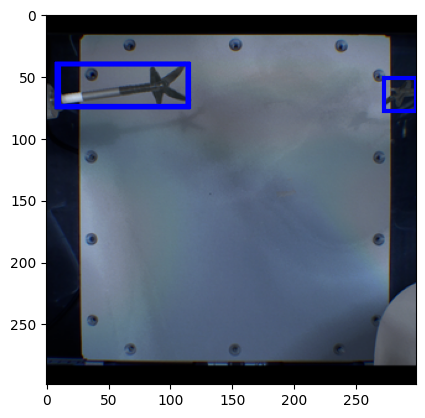

In [339]:
plt.imshow(im)

# 각 바운딩 박스를 원본 이미지에 그리기
for (xmin, ymin, xmax, ymax) in bboxes_scaled:
    # 바운딩 박스 좌표를 CPU로 이동하고, NumPy로 변환
    xmin, ymin, xmax, ymax = xmin.cpu().item(), ymin.cpu().item(), xmax.cpu().item(), ymax.cpu().item()

    # 원본 이미지에 바운딩 박스 추가
    plt.gca().add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                      fill=False, color='blue', linewidth=3))

# 그림 출력
plt.show()

In [340]:
outputs['pred_poses']

tensor([[[ 0.1842,  0.6875,  0.7046, -0.4346, -0.4617,  0.2564],
         [ 0.1826,  0.6846,  0.7025, -0.4373, -0.4608,  0.2590],
         [ 0.1821,  0.6844,  0.7022, -0.4398, -0.4614,  0.2573],
         [ 0.1656,  0.6828,  0.7097, -0.3715, -0.4348,  0.2340],
         [ 0.1831,  0.6846,  0.7026, -0.4383, -0.4611,  0.2578],
         [ 0.1826,  0.6847,  0.7032, -0.4397, -0.4611,  0.2576],
         [ 0.1856,  0.6871,  0.7056, -0.4425, -0.4635,  0.2505],
         [-0.5995,  0.6597,  0.7487, -0.0282,  0.3139, -0.3911],
         [ 0.1827,  0.6856,  0.7035, -0.4393, -0.4611,  0.2564],
         [ 0.1827,  0.6851,  0.7029, -0.4388, -0.4610,  0.2586]]],
       device='cuda:0', grad_fn=<SelectBackward0>)

In [341]:
# 역정규화에 사용할 스케일링 값들
scale_factors = torch.tensor([150, 100, 450, 180, 180, 180], device='cuda:0')

# 각 pred_poses 텐서의 값을 역정규화 (곱하기)
pred_poses_original = outputs['pred_poses'] * scale_factors

# 소수점 이하 자릿수 제한 없이 정수로 변환
pred_poses_int = pred_poses_original.round().long()

# 텐서 출력
print(pred_poses_int)


tensor([[[ 28,  69, 317, -78, -83,  46],
         [ 27,  68, 316, -79, -83,  47],
         [ 27,  68, 316, -79, -83,  46],
         [ 25,  68, 319, -67, -78,  42],
         [ 27,  68, 316, -79, -83,  46],
         [ 27,  68, 316, -79, -83,  46],
         [ 28,  69, 318, -80, -83,  45],
         [-90,  66, 337,  -5,  56, -70],
         [ 27,  69, 317, -79, -83,  46],
         [ 27,  69, 316, -79, -83,  47]]], device='cuda:0')


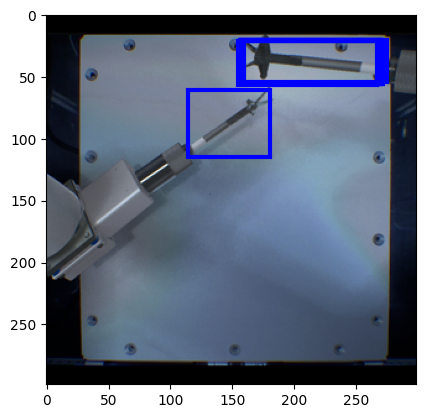

In [290]:
plt.imshow(im)

# 각 바운딩 박스를 원본 이미지에 그리기
for (xmin, ymin, xmax, ymax) in bboxes_scaled:
    # 바운딩 박스 좌표를 CPU로 이동하고, NumPy로 변환
    xmin, ymin, xmax, ymax = xmin.cpu().item(), ymin.cpu().item(), xmax.cpu().item(), ymax.cpu().item()

    # 원본 이미지에 바운딩 박스 추가
    plt.gca().add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                      fill=False, color='blue', linewidth=3))

# 그림 출력
plt.show()